# Chapter 13

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [4]:
from modsim import State, System

def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [5]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [6]:
from numpy import arange

def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in arange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [7]:
def calc_total_infected(results, system):
    s_0 = results.S[system.t0]
    s_end = results.S[system.t_end]
    return s_0 - s_end

In the previous chapters I presented an SIR model of infectious disease, specifically the Kermack-McKendrick model. We extended the model to include vaccination and the effect of a hand-washing campaign, and used the extended model to allocate a limited budget optimally, that is, to minimize the number of infections.

But we assumed that the parameters of the model, contact rate and
recovery rate, were known. In this chapter, we explore the behavior of
the model as we vary these parameters, use analysis to understand these relationships better, and propose a method for using data to estimate parameters.

## Sweeping beta

Recall that $\beta$ is the contact rate, which captures both the
frequency of interaction between people and the fraction of those
interactions that result in a new infection. If $N$ is the size of the
population and $s$ is the fraction that's susceptible, $s N$ is the
number of susceptibles, $\beta s N$ is the number of contacts per day
between susceptibles and other people, and $\beta s i N$ is the number
of those contacts where the other person is infectious.

As $\beta$ increases, we expect the total number of infections to
increase. To quantify that relationship, I'll create a range of values
for $\beta$:

In [10]:
from numpy import linspace

beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

Then run the simulation for each value and print the results.

In [13]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(beta, calc_total_infected(results, system))

0.1 0.0072309016649785285
0.2 0.038410532615067994
0.30000000000000004 0.33703425948982
0.4 0.6502429153895082
0.5 0.8045061124629623
0.6 0.8862866308018508
0.7000000000000001 0.9316695082755875
0.8 0.9574278300784942
0.9 0.9720993156325133
1.0 0.9803437149675784
1.1 0.9848347293510136


We can wrap that code in a function and store the results in a
`SweepSeries` object:

In [14]:
def sweep_beta(beta_array, gamma):
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[beta] = calc_total_infected(results, system)
    return sweep

Now we can run `sweep_beta` like this:

In [15]:
infected_sweep = sweep_beta(beta_array, gamma)

And plot the results:

In [23]:
label = f'gamma = {gamma}'
label

'gamma = 0.25'

The first line uses string operations to assemble a label for the
plotted line:

-   When the `+` operator is applied to strings, it joins them
    end-to-end, which is called **concatenation**.

-   The function `str` converts any type of object to a String
    representation. In this case, `gamma` is a number, so we have to
    convert it to a string before trying to concatenate it.

If the value of `gamma` is `0.25`, the value of `label` is the string
`'gamma = 0.25'`.

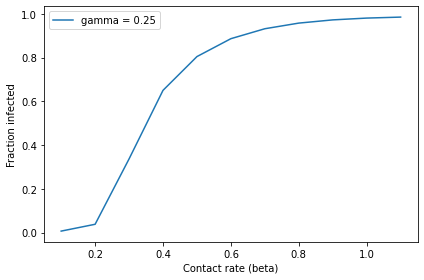

In [25]:
infected_sweep.plot(label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

Remember that this figure
is a parameter sweep, not a time series, so the x-axis is the parameter
`beta`, not time.

When `beta` is small, the contact rate is low and the outbreak never
really takes off; the total number of infected students is near zero. As
`beta` increases, it reaches a threshold near 0.3 where the fraction of
infected students increases quickly. When `beta` exceeds 0.5, more than
80% of the population gets sick.

## Sweeping gamma

Let's see what that looks like for a few different values of `gamma`.
Again, we'll use `linspace` to make an array of values:

In [26]:
gamma_array = linspace(0.1, 0.7, 4)

And run `sweep_beta` for each value of `gamma`:

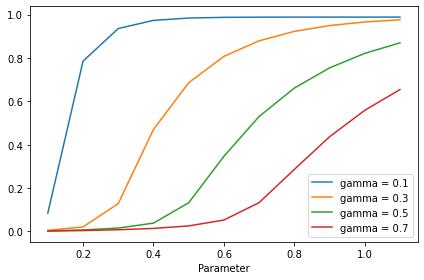

In [28]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'gamma = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate()

The following figure shows the results. When `gamma` is low, the
recovery rate is low, which means people are infectious longer. In that
case, even a low contact rate (`beta`) results in an epidemic.

When `gamma` is high, `beta` has to be even higher to get things going.

## SweepFrame

In the previous section, we swept a range of values for `gamma`, and for
each value, we swept a range of values for `beta`. This process is a
**two-dimensional sweep**.

If we want to store the results, rather than plot them, we can use a
`SweepFrame`, which is a kind of `DataFrame` where the rows sweep one
parameter, the columns sweep another parameter, and the values contain
metrics from a simulation.

This function shows how it works:

In [29]:
def sweep_parameters(beta_array, gamma_array):
    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma)
    return frame

`sweep_parameters` takes as parameters an array of values for `beta` and
an array of values for `gamma`.

It creates a `SweepFrame` to store the results, with one column for each
value of `gamma` and one row for each value of `beta`.

Each time through the loop, we run `sweep_beta`. The result is a
`SweepSeries` object with one element for each value of `beta`. The
assignment inside the loop stores the `SweepSeries` as a new column in
the `SweepFrame`, corresponding to the current value of `gamma`.

At the end, the `SweepFrame` stores the fraction of students infected
for each pair of parameters, `beta` and `gamma`.

We can run `sweep_parameters` like this:

In [30]:
frame = sweep_parameters(beta_array, gamma_array)

With the results in a `SweepFrame`, we can plot each column like this:

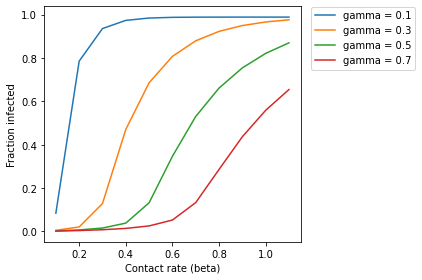

In [32]:
for gamma in gamma_array:
    label = f'gamma = {gamma}'
    plot(frame[gamma], label=label)

decorate(xlabel='Contact rate (beta)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

Alternatively, we can plot each row like this:

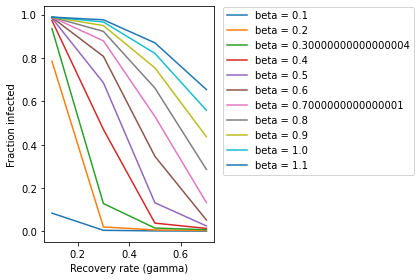

In [34]:
for beta in beta_array:
    label = f'beta = {beta}'
    plot(frame.loc[beta], label=label)
    
decorate(xlabel='Recovery rate (gamma)',
         ylabel='Fraction infected')

plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()

This example demonstrates one use of a `SweepFrame`: we can run the analysis once, save the results, and then generate different visualizations.

Another way to visualize the results of a two-dimensional sweep is a
**contour plot**, which shows the parameters on the axes and contour
lines, that is, lines of constant value. In this example, the value is
the fraction of students infected.

The ModSim library provides `contour`, which takes a `SweepFrame` as a
parameter:

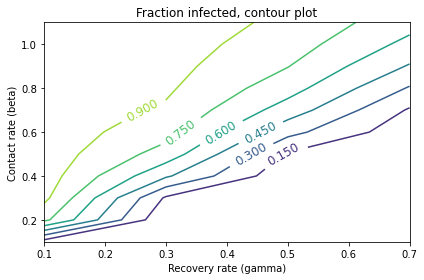

In [35]:
from modsim import contour

contour(frame)

decorate(xlabel='Recovery rate (gamma)',
         ylabel='Contact rate (beta)',
         title='Fraction infected, contour plot')

Infection rates are lowest in the lower right, where the contact rate is and the recovery rate is high. They increase as we move to the upper left, where the contact rate is high and the recovery rate is low.

This figure suggests that there might be a relationship between `beta`
and `gamma` that determines the outcome of the model. In fact, there is.
In the next chapter we'll explore it by running simulations, then derive it by analysis.



## Summary

## Exercises

**Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [15]:
# Solution

# Sweep beta with fixed gamma
gamma = 1/2
infected_sweep = sweep_beta(beta_array, gamma)

In [16]:
# Solution

# Interpolating by eye, we can see that the infection rate passes through 0.4
# when beta is between 0.6 and 0.7
# We can use the `crossings` function to interpolate more precisely
# (although we don't know about it yet :)
beta_estimate = crossings(infected_sweep, 0.4)

In [17]:
# Solution

# Time between contacts is 1/beta
time_between_contacts = 1/beta_estimate